In [1]:
% matplotlib inline

In [227]:
import pandas as pd
import numpy as np
import pickle
import seaborn 
from sklearn.metrics import accuracy_score as acc
seaborn.set_style("whitegrid")

from pandas.tools.plotting import parallel_coordinates
import matplotlib
from matplotlib import pyplot as plt
font = {'family' : 'STIXGeneral',
        'weight' : 'normal',
        'size'   : 40
       }

matplotlib.rc('font', **font)

from matplotlib import rc
rc('text', usetex=True)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [242]:
users = ["naichun", "karson", "kim"]
experiments = ["inclusion","diverse","redundant"]

In [243]:
# Since trials were randomized, re-construct the indices for trials to map trials together across users

lines_per_trial = 44
trials = 100

# Fetch lines of experiments for each user
lines = [line.rstrip('\n') for line in open('kim.txt')]
lines2 = [line.rstrip('\n') for line in open('karson.txt')]
lines3 = [line.rstrip('\n') for line in open('naichun.txt')] + ["MISSING LINE"]*24

# Create index mapping of question to index.
txt2index = {" ".join(lines[i*lines_per_trial:(i+1)*lines_per_trial][1:]):i for i in range(trials)}

# Produces indices for each user's text
kim_index = [txt2index.get(" ".join(lines[i*lines_per_trial:(i+1)*lines_per_trial][1:])) for i in range(trials)]
karson_index = [txt2index.get(" ".join(lines2[i*lines_per_trial:(i+1)*lines_per_trial][1:])) for i in range(trials)]
naichun_index = [txt2index.get(" ".join(lines3[i*lines_per_trial:(i+1)*lines_per_trial][1:])) for i in range(trials)]
naichun_index[-1] = 28 # Fixes error in last entry

In [244]:
# Fetch results from csv files and combine
mmr_results = []
for user in users:
  response = pd.read_csv("response_{user}.csv".format(user=user))
  response.columns = ["inclusion","diverse", "redundant"]
  truth = pd.DataFrame(list(pd.read_pickle("truth_{user}.txt.p".format(user=user))))
  combined = pd.concat([response, truth], axis=1)
  combined["user"] = [user] * len(combined)
  mmr_results.append(combined)
mmr_results = pd.concat(mmr_results, ignore_index=True) # Combines list of dataframes into single dataframe

In [245]:
# Modify two errors in the data.
mmr_results.ix[99] = ["B", "B", "A", "baseline", "mmr", 0.75, "naichun"]
mmr_results.ix[72] = ["A", "A", "B", "mmr", "baseline", 0.75, "naichun"]

In [246]:
# Map A and B (blinded trials) to actual values.
mmr_results["mapping"] = mmr_results[["A","B"]].T.to_dict().values()
mmr_results[experiments] = mmr_results[["inclusion","diverse","redundant", "mapping"]].apply(lambda x: pd.Series([x["mapping"][x["inclusion"]], x["mapping"][x["diverse"]], x["mapping"][x["redundant"]]]), axis=1)
mmr_results = mmr_results[["inclusion","diverse","redundant", "mmr_lambda", "user"]]

In [247]:
# Re-arrange each users trials so that results are in the same order.
sorted_mmr_results = []
for user in users:
  user_slice = mmr_results[mmr_results["user"] == user]
  user_slice["trial_index"] = eval(user+"_index")
  user_slice = user_slice.sort_values("trial_index") #.drop("trial_index", axis=1)
  sorted_mmr_results.append(user_slice)
mmr_results = pd.concat(sorted_mmr_results)

/Users/cgn/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [248]:
# Store results as csv
mmr_results.to_csv("mmr_results.csv.gz", compression="gzip", index=False)
mmr_results = pd.read_csv("mmr_results.csv.gz", compression="gzip")

In [251]:
# Aggregater results per lambda and per user.
final_per_user = []
for user in users:
  final_per_lam = []
  for mmr_lambda in mmr_results.mmr_lambda.unique():
    df_lam = mmr_results[mmr_results.user == user]
    df_lam = df_lam[df_lam.mmr_lambda == mmr_lambda][experiments]
    df_lam = pd.DataFrame([df_lam[col].value_counts() for col in df_lam.columns])
    df_lam["ntrials"] = df_lam["baseline"] + df_lam["mmr"]
    df_lam = df_lam[["ntrials", "baseline", "mmr"]]
    df_lam["fraction_baseline"] = df_lam["baseline"] / df_lam["ntrials"]
    df_lam["fraction_mmr"] = df_lam["mmr"] / df_lam["ntrials"]
    df_lam["mmr_lambda"] = [mmr_lambda] * len(df_lam)
    final_per_lam.append(df_lam)
  final_per_user.append(pd.DataFrame({i: df["fraction_mmr"] for i, df in pd.concat(final_per_lam).groupby("mmr_lambda")}))
  
df_concat = pd.concat(final_per_user)
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
df_stds = by_row_index.std()

df_concat["Rater"] = [1,1,1,2,2,2,3,3,3] 
df_concat['Experiment'] = [2,1,3] * 3

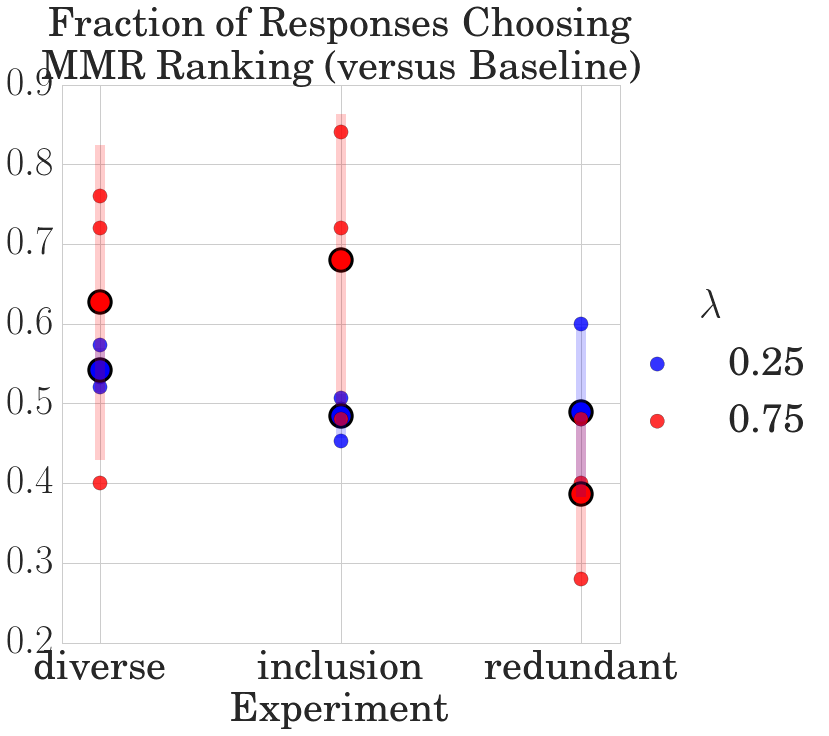

In [254]:
# Plot final results
color_map = {0.25:"blue", 0.75:"red"}
alpha=0.2
plt.figure(figsize=(10,10))
for mmr_lambda in df_means.columns:
  plt.scatter(df_concat["Experiment"], df_concat[mmr_lambda], label=mmr_lambda, s=200, c = color_map[mmr_lambda], alpha=0.8)
  avg = df_means[mmr_lambda]
  std = df_stds[mmr_lambda]
  plt.scatter([1,2,3], avg, s=500, linewidth=3, c = color_map[mmr_lambda])
  plt.errorbar([1,2,3], avg, yerr=std, fmt='none', linewidth=10, alpha=alpha, ecolor = color_map[mmr_lambda])
  #plt.fill_between([1,2,3], avg-std, avg+std, alpha=alpha)
  plt.xticks([1,2,3], avg.index)
plt.legend(bbox_to_anchor=(1.4, .5), loc = 5, fontsize=40, title=r"\lambda")
plt.tick_params(axis='both', which='both', labelsize=40)
plt.title("Fraction of Responses Choosing\nMMR Ranking (versus Baseline)", fontsize=40)
plt.xlabel("Experiment", fontsize=40)
plt.savefig("mmr_figure.pdf", dpi=300, bbox_inches='tight')

In [255]:
# Produce final latex table for paper
final = []
for mmr_lambda in mmr_results.mmr_lambda.unique():
  df_lam = mmr_results[mmr_results.mmr_lambda == mmr_lambda][experiments]
  df_lam = pd.DataFrame([df_lam[col].value_counts() for col in df_lam.columns])
  df_lam["ntrials"] = df_lam["baseline"] + df_lam["mmr"]
  df_lam = df_lam[["ntrials", "baseline", "mmr"]]
  df_lam["fraction_baseline"] = df_lam["baseline"] / df_lam["ntrials"]
  df_lam["fraction_mmr"] = df_lam["mmr"] / df_lam["ntrials"]
  df_lam["mmr_lambda"] = [mmr_lambda] * len(df_lam)
  final.append(df_lam)
final = pd.concat(final)

final = final.reset_index().rename(columns={"index":"experiment"}).set_index(["mmr_lambda", "experiment"])
final["fraction_baseline"] = final["fraction_baseline"].apply(lambda x: round(x, 2))
final["fraction_mmr"] = final["fraction_mmr"].apply(lambda x: round(x, 2))
print final.to_latex()

\begin{tabular}{llrrrrr}
\toprule
     &         &  ntrials &  baseline &  mmr &  fraction\_baseline &  fraction\_mmr \\
mmr\_lambda & experiment &          &           &      &                    &               \\
\midrule
0.25 & inclusion &      225 &       116 &  109 &               0.52 &          0.48 \\
     & diverse &      225 &       103 &  122 &               0.46 &          0.54 \\
     & redundant &      225 &       115 &  110 &               0.51 &          0.49 \\
0.75 & inclusion &       75 &        24 &   51 &               0.32 &          0.68 \\
     & diverse &       75 &        28 &   47 &               0.37 &          0.63 \\
     & redundant &       75 &        46 &   29 &               0.61 &          0.39 \\
\bottomrule
\end{tabular}



In [256]:
# Compute inter-rater reliablity

In [257]:
from sklearn.metrics import cohen_kappa_score

In [260]:
df_cohen = mmr_results.set_index(["user"])
cohen = {}

for exp in experiments:
  for name1 in mmr_results.user.unique():
      cohen[exp, name1] = [cohen_kappa_score(df_cohen.ix[name1][exp], df_cohen.ix[name2][exp]) for name2 in mmr_results.user.unique() if name1 != name2]
      
print pd.DataFrame(cohen, index=["other1", "other2"]).transpose().to_latex()
pd.DataFrame(cohen, index=["other1", "other2"]).transpose()

\begin{tabular}{llrr}
\toprule
        &        &    other1 &    other2 \\
\midrule
diverse & karson & -0.010918 &  0.273901 \\
        & kim &  0.179319 &  0.273901 \\
        & naichun & -0.010918 &  0.179319 \\
inclusion & karson &  0.033912 &  0.146825 \\
        & kim &  0.185336 &  0.146825 \\
        & naichun &  0.033912 &  0.185336 \\
redundant & karson & -0.025851 &  0.135560 \\
        & kim &  0.211045 &  0.135560 \\
        & naichun & -0.025851 &  0.211045 \\
\bottomrule
\end{tabular}



other1    other2
diverse   karson  -0.010918  0.273901
          kim      0.179319  0.273901
          naichun -0.010918  0.179319
inclusion karson   0.033912  0.146825
          kim      0.185336  0.146825
          naichun  0.033912  0.185336
redundant karson  -0.025851  0.135560
          kim      0.211045  0.135560
          naichun -0.025851  0.211045

In [261]:
# Compute fraction agreement
df_cohen = mmr_results.set_index(["user"])
agreement = {}

for exp in experiments:
  for name1 in mmr_results.user.unique():
      agreement[exp, name1] = [acc(df_cohen.ix[name1][exp], df_cohen.ix[name2][exp]) for name2 in mmr_results.user.unique() if name1 != name2]

print pd.DataFrame(agreement, index=["other1", "other2"]).transpose().to_latex()
pd.DataFrame(agreement, index=["other1", "other2"]).transpose()

\begin{tabular}{llrr}
\toprule
        &        &  other1 &  other2 \\
\midrule
diverse & karson &    0.50 &    0.64 \\
        & kim &    0.60 &    0.64 \\
        & naichun &    0.50 &    0.60 \\
inclusion & karson &    0.51 &    0.57 \\
        & kim &    0.60 &    0.57 \\
        & naichun &    0.51 &    0.60 \\
redundant & karson &    0.50 &    0.56 \\
        & kim &    0.60 &    0.56 \\
        & naichun &    0.50 &    0.60 \\
\bottomrule
\end{tabular}



other1  other2
diverse   karson     0.50    0.64
          kim        0.60    0.64
          naichun    0.50    0.60
inclusion karson     0.51    0.57
          kim        0.60    0.57
          naichun    0.51    0.60
redundant karson     0.50    0.56
          kim        0.60    0.56
          naichun    0.50    0.60